<a href="https://colab.research.google.com/github/AllanAlvarez1/CMP-464-Project-1-/blob/main/Allan_Revision_2_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1

In this project, you will develop a deep learning model to classify lung nodules as benign or malignant from 3D CT scans, utilizing the LUNA16 dataset. This task involves data preprocessing, model design, training, and evaluation, offering hands-on experience with medical image analysis and deep learning in PyTorch.

## 1. Create Annotation Data
As the first step, we will need to load the annotation data from Kaggle's data page: [Luna 16 Lung Cancer Dataset on Kaggle](https://www.kaggle.com/datasets/fanbyprinciple/luna-lung-cancer-dataset)

1.1 Download the annotation dataset from Kaggle.

In [ ]:
#Install kaggle api
! pip install -q kaggle

In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leonmonkey1themyth","key":"a70aa4f59327c759dc7f975c85663a1b"}'}

In [ ]:
#Make a directory for kaggle and copy the json there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
#display the content of the folder
! ls ~/.kaggle

kaggle.json


In [ ]:
#Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Check if the Luna16 dataset is accessible
! kaggle datasets list -s 'luna16'

ref                                      title                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------  ---------------------------  -----  -------------------  -------------  ---------  ---------------  
avc0706/luna16                           Luna16                        32GB  2020-11-19 04:17:45           3289         43  0.64705884       
fanbyprinciple/luna-lung-cancer-dataset  Luna16 Lung Cancer Dataset   330MB  2021-03-14 03:54:34           6569         71  0.8235294        
kmader/lungnodemalignancy                Lung Nodule Malignancy        95MB  2017-09-21 15:36:33           4120         67  0.8235294        
sinyouchang/luna16                       LUNA16                        37GB  2020-09-16 14:34:28            134          5  0.1875           
amirrezamousavi/luna16                   luna16subset0to5              38GB  2022-09-17 11:55:34            162          2  0.7647059        
mashru

In [ ]:
#download the data
! kaggle datasets download -d 'fanbyprinciple/luna-lung-cancer-dataset'

Dataset URL: https://www.kaggle.com/datasets/fanbyprinciple/luna-lung-cancer-dataset
License(s): CC-BY-SA-3.0
 96% 317M/330M [00:02<00:00, 150MB/s]
100% 330M/330M [00:02<00:00, 119MB/s]


In [ ]:
#unzip the data
! unzip luna-lung-cancer-dataset.zip -d luna16

Archive:  luna-lung-cancer-dataset.zip
  inflating: luna16/annotations.csv  
  inflating: luna16/candidates.csv   
  inflating: luna16/candidates_V2/candidates_V2.csv  
  inflating: luna16/evaluationScript/evaluationScript/NoduleFinding.py  
  inflating: luna16/evaluationScript/evaluationScript/annotations/annotations.csv  
  inflating: luna16/evaluationScript/evaluationScript/annotations/annotations_excluded.csv  
  inflating: luna16/evaluationScript/evaluationScript/annotations/seriesuids.csv  
  inflating: luna16/evaluationScript/evaluationScript/exampleFiles/evaluation/CADAnalysis.txt  
  inflating: luna16/evaluationScript/evaluationScript/exampleFiles/evaluation/FROC_sampleSubmission.png  
  inflating: luna16/evaluationScript/evaluationScript/exampleFiles/evaluation/froc_gt_prob_vectors_sampleSubmission.csv  
  inflating: luna16/evaluationScript/evaluationScript/exampleFiles/evaluation/froc_sampleSubmission.txt  
  inflating: luna16/evaluationScript/evaluationScript/exampleFiles/e

1.2 Load the `candidates_V2.csv` file as a data frame. Display the first 5 rows.

In [ ]:
import pandas as pd
candidates = pd.read_csv('/content/luna16/candidates_V2/candidates_V2.csv')

In [ ]:
#print the first few lines of the file
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [ ]:
#count the number of lines in the file
print("Shape:", candidates.shape)

Shape: (754975, 5)


1.3 Display the number of class 0 (benign) records and the number of class 1 (malignant) records. Your results should indicate that the two classes are highly imbalanced.

In [ ]:
#Display the number of benign and malignant
candidates['class'].value_counts()

,count
class,
0,753418
1,1557


In [ ]:
#create annotation data
annotations = pd.read_csv("luna16/annotations.csv")
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


## 2. Find Nodule Locations
In the annotation dataset, the center of each identified lung nodule is marked with its 3D coordinates. We need to convert these coordinates into three indices to identify the specific subarray in each CT scan tensor that corresponds to the nodule.

Please follow the steps outlined in the LUNA16DataPreparation notebook to generate a CSV file named `candidates_processed.csv`, which will store the indices for the center of each lung nodule.

2.1 Load the `subset0.zip` from Google Drive using the file ID '1OFa8UhDvCrcTj1VkFLa7RjifEqMD4TAa'. Extract the zip file to reveal the .mhd and .raw files.

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 8.8 MB/s eta 0:00:00


In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#download the subset using the right ID
id='1OFa8UhDvCrcTj1VkFLa7RjifEqMD4TAa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('subset0.zip')

In [ ]:
#unzip the subset file
! unzip -q subset0.zip

In [ ]:
#Find a few positive smaples

# Extract UIDs from files in subset0 folder
all_mhd = glob.glob('subset0/*.mhd')
name = all_mhd[0]
start_index = name.find('1.')
end_index = name.find('.mhd')
# print(start_index, end_index)
print("ID:", name[start_index:end_index])
ids = [name[start_index:end_index] for name in all_mhd]
print("ID list:", ids)

samples = candidates[(candidates['class'] == 1) &
           (candidates['seriesuid'].isin(ids))].sample(5)
samples

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345
ID list: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345', '1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223', '1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733', '1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441', '1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321', '1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986', '1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176', '1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827', '1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718', '1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430', '1.3.6.1.4.1.14519.5.2.1.6279.6001.18

,seriesuid,coordX,coordY,coordZ,class
531006,1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531...,-87.270657,-49.517760,-116.886270,1
296147,1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221...,-86.579580,-17.249667,-52.926473,1
564581,1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433...,-88.787853,208.698595,-397.239369,1
472496,1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...,60.273439,6.787187,-166.360000,1
307353,1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...,99.316706,65.931161,-90.892185,1


In [ ]:
#find the value of the first seriesuid
series_uid = samples['seriesuid'].values[0]
series_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596'

In [ ]:
#create the mhd path
mhd_path = 'subset0/{}.mhd'.format(series_uid)
mhd_path

'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd'

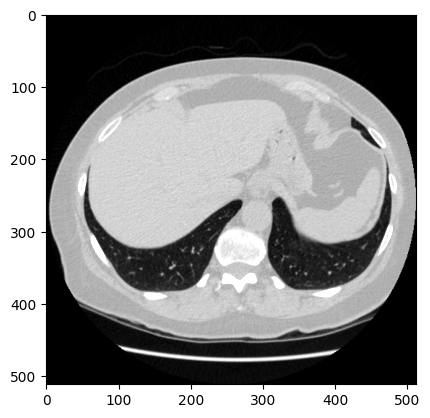

In [ ]:
ct_mhd = sitk.ReadImage(mhd_path)

ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a.clip(-1000, 1000, ct_a)
clim = (-1000, 300)

spacingX, spacingY, spacingZ = ct_mhd.GetSpacing()

plt.imshow(ct_a[100, :, :], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

2.2 Create a Pandas data frame that contains these 8 colums: `seriesuid`, `coordX`, `coordY`, `coordZ`, `class`, `index`, `row`, `col`. The last three columns should be calculated using the three coordiantes and the information about the origin and spacing of the corresponding CT scan.

In [ ]:
num_rows = len(ids)
ct_info = pd.DataFrame(np.zeros([num_rows, 6]), columns=['originX', 'originY', 'originZ', 'spacingX', 'spacingY', 'spacingZ'], index=ids)
ct_info.head()

,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345,0.0,0.0,0.0,0.0,0.0,0.0
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223,0.0,0.0,0.0,0.0,0.0,0.0
1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733,0.0,0.0,0.0,0.0,0.0,0.0
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,0.0,0.0,0.0,0.0,0.0,0.0
1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for id in ids:
    mhd_path = 'subset0/{}.mhd'.format(id)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_info.loc[id, ['originX', 'originY', 'originZ']] = list(ct_mhd.GetOrigin())
    ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']] = list(ct_mhd.GetSpacing())
    if ct_mhd.GetDirection() != (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0):
        print(id, ct_mhd.GetDirection())
print(ct_info.shape)
ct_info.head()

1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
(89, 6)


,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345,-161.640151,-32.754737,-720.750000,0.638672,0.638672,0.75
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223,-145.399994,-177.500000,-279.750000,0.693359,0.693359,1.25
1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733,-180.000000,-157.500000,-349.500000,0.703125,0.703125,2.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,-193.500000,-180.000000,-353.329987,0.703125,0.703125,2.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720,-166.399994,-157.500000,-337.480011,0.615234,0.615234,2.50


In [ ]:
# Define a uniform direction vector for all CT scans
direction_a = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
print(direction_a)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
# Convert the xyz coordinates to (index, row, column)
coordX, coordY, coordZ = samples.loc[samples.index[0], ['coordX', 'coordY', 'coordZ']]
print(coordX, coordY, coordZ)
id = samples.loc[samples.index[0], 'seriesuid']
origin_a = ct_info.loc[id, ['originX', 'originY', 'originZ']].values.reshape([-1])
vxSize_a = ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']].values.reshape([-1])
coord_a = np.array([coordX, coordY, coordZ])
cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
cri_a = np.round(cri_a)
index = int(cri_a[2])
row = int(cri_a[1])
col = int(cri_a[0])
index, row, col

-87.2706571 -49.51775953 -116.88627


(215, 177, 129)

In [ ]:
mhd_path = 'subset0/{}.mhd'.format(id)
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a.clip(-1000, 1000, ct_a)
ct_chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
ct_chunk.shape

(32, 48, 48)

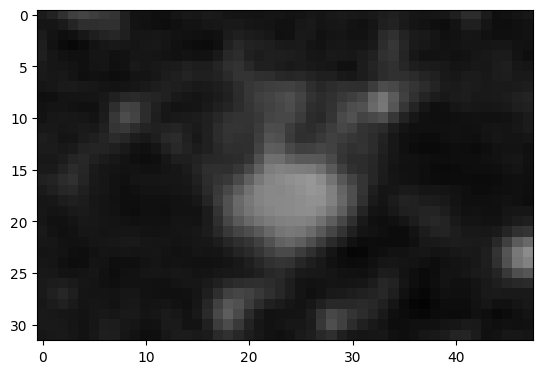

In [ ]:
spacingX, spacingY, spacingZ = ct_mhd.GetSpacing()

plt.imshow(ct_chunk[:, ct_chunk.shape[1]//2, :], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

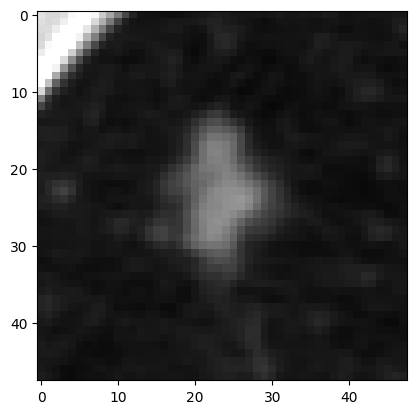

In [ ]:
plt.imshow(ct_chunk[ct_chunk.shape[0]//2, :, :], clim=clim, cmap='gray')

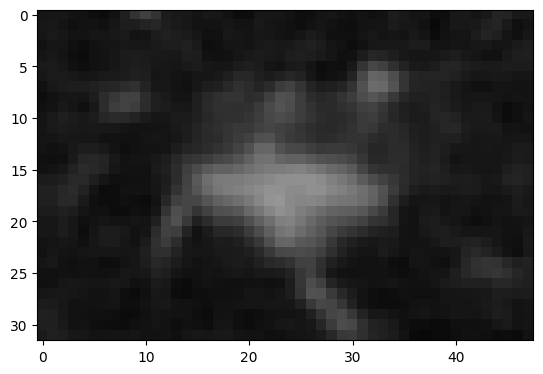

In [ ]:
plt.imshow(ct_chunk[:, :, ct_chunk.shape[2]//2], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

In [ ]:
num_nodules = len(candidates)
num_nodules

754975

In [ ]:
count = 0

# Extract the nodule from the supported CT scans.
candidates_small = candidates[candidates['seriesuid'].isin(ids)]
print(len(candidates_small))

for idx in candidates_small.index: # Go through all nodules supported by the CT scan data

    # Extract the coordinates of the nodule
    coordX, coordY, coordZ = candidates_small.loc[idx, ['coordX', 'coordY', 'coordZ']]

    # Extract the corresponding CT scan ID.
    id = candidates_small.loc[idx, 'seriesuid']

    # Convert the coordiates to indices
    origin_a = ct_info.loc[id, ['originX', 'originY', 'originZ']].values.reshape([-1])
    vxSize_a = ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']].values.reshape([-1])
    coord_a = np.array([coordX, coordY, coordZ])
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)

    # Record the indices to the data frame
    candidates_small.loc[idx, 'index'] = int(cri_a[2])
    candidates_small.loc[idx, 'row'] = int(cri_a[1])
    candidates_small.loc[idx, 'col'] = int(cri_a[0])

    count += 1
    if count % 1000 == 0:
        print(count)

79135


<ipython-input-32-3d5f527e3a8f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_small.loc[idx, 'index'] = int(cri_a[2])
<ipython-input-32-3d5f527e3a8f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_small.loc[idx, 'row'] = int(cri_a[1])
<ipython-input-32-3d5f527e3a8f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000


In [ ]:
# All rows in candidates_small should have the indices computed
candidates_small.isnull().sum()

,0
seriesuid,0
coordX,0
coordY,0
coordZ,0
class,0
index,0
row,0
col,0


In [ ]:
candidates_small.shape

(79135, 8)

In [ ]:
candidates_small.dtypes

,0
seriesuid,object
coordX,float64
coordY,float64
coordZ,float64
class,int64
index,float64
row,float64
col,float64


In [ ]:
# Convert the indices to integers
candidates_small = candidates_small.copy() # remove the connection between candidates and candidates_small
candidates_small[['index', 'row', 'col']] = candidates_small[['index', 'row', 'col']].astype(int)

In [ ]:
candidates_small.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
11673,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
11674,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
11675,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
11676,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
11677,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


2.3 Save the data frame as a CSV file named `candiadates_processed.csv`. This allows you to skip Step 2.2 in future calculations.




In [ ]:
candidates_small.to_csv('candidates_processed.csv', index=False)

In [ ]:
# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
candidates_small.to_csv('drive/MyDrive/candidates_processed.csv', index=False)

In [ ]:
temp = pd.read_csv('drive/MyDrive/candidates_processed.csv')
temp.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


In [ ]:
ct_info.to_csv("drive/MyDrive/ct_info.csv") # Keep index=True to store the indices
temp = pd.read_csv("drive/MyDrive/ct_info.csv", index_col=0) # Set the first column to be the indices
temp.head()

,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345,-161.640151,-32.754737,-720.750000,0.638672,0.638672,0.75
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223,-145.399994,-177.500000,-279.750000,0.693359,0.693359,1.25
1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733,-180.000000,-157.500000,-349.500000,0.703125,0.703125,2.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,-193.500000,-180.000000,-353.329987,0.703125,0.703125,2.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720,-166.399994,-157.500000,-337.480011,0.615234,0.615234,2.50


## 3. Create Data Tensors

The neural network model we will build with PyTorch requires the data to be presented in the form of a torch tensor. The input tensor should be 4-dimensional, with the dimensions representing the nodule index, channel, row, and column, respectively.

3.1 Write a double for-loop to extract the CT scan data for **the first 5,000*** nodules:
- The outer for loop goes through all the distince seriesuid's.
- For each iteration of the outer loop, load the corresponding CT-scan file and create a torch tensor to represent the scan.
- Create an inner-loop that goes through the nodules corresponding to the seriesuid:
    - Load the (index, row, col) tuple of this nodule from the data frame.
    - Extract a 32x48x48 chunk centered at the (index, row, col). If the nodule is near the edge of the image and there is not enough indices to extract, please pad with zeros to keep the overall shape unchanged.
    - Use a 4D tensor to contain all the 32x48x48 chunks. The first dimension of the 4D tensor is the index of nodule.

You may modify the above procedure as you like. Make sure that you are able to obtain a 4D tensor that contains all nodule data. **Display the shape of the 4D tensor.** The shape of the tensor should be (5000, 32, 48, 48).

**Remark** Due to the memory limit, it is impossible to load all nodule images into simultanously. Therefore, the number of nodules required in this section is reduced to 5,000. Feel free to adjust this number to prevent the out-of-memory error.

In [ ]:
data = pd.read_csv("drive/MyDrive/candidates_processed.csv")
data.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


In [ ]:
# Example: Extract the CT chunk for the first nodule
nodule_index = 0
seriesuid = data.loc[nodule_index, "seriesuid"]
print(seriesuid)

1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260


In [ ]:
import SimpleITK as sitk
import numpy as np
mhd_path = "subset0/" + seriesuid + ".mhd"
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a = ct_a.clip(-1000, 1000, ct_a)
ct_a.shape

(121, 512, 512)

In [ ]:
index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
index, row, col

(110, 331, 173)

3.2 Create a 1D tensor to contain all the class information.

In [ ]:
import torch
ct_chunk = torch.zeros([32, 48, 48])
chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
chunk_indices, chunk_rows, chunk_cols = chunk.shape
print(chunk.shape) # If the nodule is near the boundary, the extract chunk may
                   # have a smaller size
ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
ct_chunk.shape

(27, 48, 48)


torch.Size([32, 48, 48])

In [ ]:
ct_chunk[-6:, :3, :3] # zeros are added to the end of the first dimension

tensor([[[ 51.,  15., -10.],
         [136., 103., 123.],
         [ 86.,  95.,  41.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]])

In [ ]:
num_nodules = 5000

# Build an empty input tensor and an empty output tensor
chunks = torch.zeros([num_nodules, 32, 48, 48])
labels = torch.zeros([num_nodules])

In [ ]:

# create a for loop to go through all CT scan files.
import glob
all_files = glob.glob('subset0/*.mhd')

count = 0

for file in all_files:
    # print(file)
    # Load the file as an array
    ct_mhd = sitk.ReadImage(file)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    # Extract the ID from the file name.
    start_index = file.find('1.')
    end_index = file.find('.mhd')
    id = file[start_index:end_index]

    # for each CT scan load nodules from it.
    nodules = data[data['seriesuid'].str.contains(id)]

    # print(nodules.index)

    # Loop through these nodules and create a subarray for each one.
    # We no longer need to reload the CT scan file.
    for nodule_index in nodules.index:
        # Extract the indices for the center
        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]

        # Build a 32x48x48 tensor to represent the nodule.
        # We need to add 0s if the nodule is too close to the boundary
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
        if chunk.shape[0] < 32:
            print("Padding on the first dimension is applied.")
        elif chunk.shape[1] < 48:
            print("Padding on the second dimension is applied.")
        elif chunk.shape[2] < 48:
            print("Padding on the third dimension is applied.")

        # Add this 3D tensor to the 4D tensor.
        chunks[count, :, :, :] = ct_chunk

        # Add the corresponding label to the label tensor
        labels[count] = data.loc[nodule_index, 'class']

        count += 1
        print(count)
        if count == num_nodules - 1:
            break # break out of the inner loop
    if count == num_nodules - 1:
        break # break out of the outer loop


Streaming output truncated to the last 5000 lines.
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
3

3.3 Split the 4D tensor into a training set and a test set. Display their shapes.

In [ ]:
chunks.shape, labels.shape


(torch.Size([5000, 32, 48, 48]), torch.Size([5000]))

In [ ]:
from sklearn.model_selection import train_test_split
chunks_train, chunks_test, labels_train, labels_test = train_test_split(chunks, labels, test_size=0.2)
print(chunks_train.shape, labels_train.shape)
print(chunks_test.shape, labels_test.shape)

torch.Size([4000, 32, 48, 48]) torch.Size([4000])
torch.Size([1000, 32, 48, 48]) torch.Size([1000])


## 4. Model Design and Implementation

4.1 Design a neural network model with only a flatten layer and two dense layers for classifying lung nodules. You may experiment with different sizes for the hidden layers to improve the training results.

In [ ]:
number_input_values = 32 * 48 * 48

In [ ]:
#Make a CNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
class LunaModel(nn.Module):
    def __init__(self, num_classes=64):
        super().__init__()
        #One flat layer
        self.flatten = nn.Flatten()
        #Two dense layers
        self.fc1 = nn.Linear(number_input_values, 128)
        self.fc2 = nn.Linear(128, num_classes)
        #Define the forward pass
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [ ]:
model = LunaModel()

4.2 Create an object to represent the loss function.

In [ ]:
loss_function = nn.CrossEntropyLoss()

4.3 Create an object to represent the optimizer.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4.4 Create a function to represent the training loop.


In [ ]:
dataset = torch.utils.data.TensorDataset(chunks.unsqueeze(1), labels)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
def train(model, loss_function, optimizer, train_loader, num_epochs):
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # Assuming your dataloader provides the inputs and the labels
          inputs, labels = data[0], data[1].long()  # Ensure labels are long and correct shape

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          # print(labels.shape, outputs.shape)
          # print(outputs)
          # loss = loss_function(outputs[0], labels)  # Original line causing the error
          loss = loss_function(outputs, labels)  # Pass the entire outputs to the loss function
          # print(loss)

          # Backward pass and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print('Epoch: %d, loss: %.4f' %
            (epoch + 1, running_loss / 100))
      running_loss = 0.0

4.5 Execute the training loop. Display the change of training loss during the training process. Choose a reasonable value for the number of training epochs based on your observations.

In [ ]:
train(model, loss_function, optimizer, train_loader, 5)

Epoch: 1, loss: 574377443077.3159
Epoch: 2, loss: 43361577261.2424
Epoch: 3, loss: 37192630629940.2266
Epoch: 4, loss: 11937741304507295744.0000
Epoch: 5, loss: 43859890989531574304768.0000


## 5. Model Evaluation and Analysis

5.1 Obtain the model's prediction on the test set.

In [ ]:
#Luna 16 Modeling Week 11 for Overview on how to move on from here
predictions = torch.argmax(model(chunks_test.unsqueeze(1)), dim=1)
predictions.shape

torch.Size([1000])

5.2 Calculate the report the following metrics:
- accuracy
- precision
- recall

5.3: Discuss the model's performance.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.998
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 6. Data Augmentation and Retraining

To enhance the model's performance, it is essential to increase the number of malignant instances. Apply random shifting and rotation to generate new training instances, ensuring an equal number of instances in each class within the training set.

6.1 Augment the number of malignent instances in the training set.

In [ ]:
#find one positive instance
data = pd.read_csv("drive/MyDrive/candidates_processed.csv")
data['class'].value_counts()

,count
class,
0,78997
1,138


In [ ]:
data_positive = data[data['class'] == 1]
data_positive.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
1512,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.709660,68.191806,-230.920000,1,33,348,110
2225,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.577827,77.166931,-123.632500,1,56,338,409
2400,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,45.517008,48.789231,-109.205277,1,68,286,425
3109,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.297029,117.290290,-182.063909,1,187,351,427
5070,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,146.239444,-161.190112,-310.777295,1,41,229,458


In [ ]:
nodule_index = data_positive.index[0]
uid = data_positive.loc[nodule_index, 'seriesuid']

mhd_path = 'subset0/{}.mhd'.format(uid)
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a = ct_a.clip(-1000, 1000, ct_a)

index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
ct_chunk = torch.zeros([32, 48, 48])
chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
chunk_indices, chunk_rows, chunk_cols = chunk.shape
ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
label = data.loc[nodule_index, 'class']

ct_chunk.shape, label

(torch.Size([32, 48, 48]), 1)

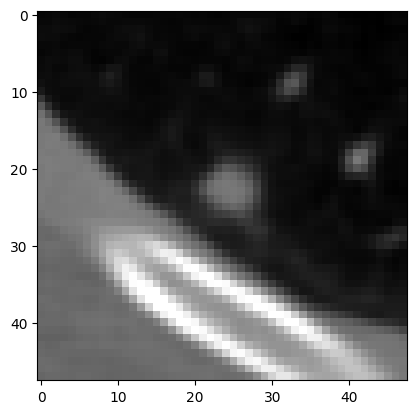

In [ ]:
# Visualize the nodule
import matplotlib.pyplot as plt
plt.imshow(ct_chunk[16, :, :], cmap='gray')
plt.show()

In [ ]:
# Create a new dataset with equal numbers of positives and negatives.
num_negatives = 2500
num_positives = 100
num_copies = 25

negative_chunks = torch.zeros([num_negatives, 32, 48, 48])
negative_labels = torch.zeros([num_negatives])
count = 0

for uid in data['seriesuid'].unique():
    subdata = data[data['seriesuid'] == uid]
    print("ID:", uid, "Nodules:", subdata.shape[0])

    mhd_path = 'subset0/{}.mhd'.format(uid)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    for nodule_index in subdata.index:

        if data.loc[nodule_index, 'class'] == 0:
            index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
            ct_chunk = torch.zeros([32, 48, 48])
            chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
            chunk_indices, chunk_rows, chunk_cols = chunk.shape
            ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
            negative_chunks[count, :, :, :] = ct_chunk
            negative_labels[count] = data.loc[nodule_index, 'class']
            count += 1

        if count == num_negatives:
            break
    if count == num_negatives:
        break
print(negative_chunks.shape, negative_labels.shape)

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 Nodules: 707
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 Nodules: 1291
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 Nodules: 804
torch.Size([2500, 32, 48, 48]) torch.Size([2500])


In [ ]:
from torchvision.transforms import RandomAffine

positive_chunks = torch.zeros([num_positives * num_copies, 32, 48, 48])
positive_labels = torch.zeros([num_positives * num_copies])
count = 0
shift_fn = RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)
for uid in data['seriesuid'].unique():
    subdata = data[data['seriesuid'] == uid]
    print("ID:", uid, "Nodules:", subdata.shape[0])

    mhd_path = 'subset0/{}.mhd'.format(uid)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    for nodule_index in subdata.index:

        if data.loc[nodule_index, 'class'] == 1:
            index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
            ct_chunk = torch.zeros([32, 48, 48])
            chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
            chunk_indices, chunk_rows, chunk_cols = chunk.shape
            ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
            positive_chunks[count * num_copies, :, :, :] = ct_chunk
            positive_labels[count * num_copies] = data.loc[nodule_index, 'class']


            # Add augumented chunks
            for i in range(1, num_copies):
                shifted_chunk = shift_fn(ct_chunk)
                positive_chunks[count * num_copies + i, :, :, :] = shifted_chunk
                positive_labels[count * num_copies + i] = data.loc[nodule_index, 'class']

            count += 1
            print(count)

        if count == num_positives:
            break
    if count == num_positives:
        break
print(positive_chunks.shape, positive_labels)

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 Nodules: 707
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 Nodules: 1291
1
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 Nodules: 804
2
3
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987 Nodules: 730
4
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720 Nodules: 821
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565 Nodules: 1333
5
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514 Nodules: 615
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354 Nodules: 1129
6
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 Nodules: 1083
7
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950 Nodules: 961
8
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843 Nodules: 1262
9
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441 Nodule

In [ ]:
# Combine the positive and negative instances.
chunks = torch.cat([negative_chunks, positive_chunks], dim=0)
labels = torch.hstack([negative_labels, positive_labels])
print(chunks.shape, labels.shape)

torch.Size([5000, 32, 48, 48]) torch.Size([5000])


6.2 Retrain the neural network model on the new training set.

In [ ]:
import torch.optim as optim
model = LunaModel()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
loss_fn = nn.CrossEntropyLoss()
dataset = torch.utils.data.TensorDataset(chunks.unsqueeze(1), labels)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
def datatrain(model, loss_function, optimizer, train_loader, num_epochs):
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # Assuming your dataloader provides the inputs and the labels
          inputs, labels = data[0], data[1].long()  # Ensure labels are long and correct shape

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          # print(labels.shape, outputs.shape)
          # print(outputs)
          # loss = loss_function(outputs[0], labels)  # Original line causing the error
          loss = loss_function(outputs, labels)  # Pass the entire outputs to the loss function
          # print(loss)

          # Backward pass and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print('Epoch: %d, loss: %.4f' %
            (epoch + 1, running_loss / 100))
      running_loss = 0.0

In [ ]:
datatrain(model, loss_fn, optimizer, train_loader, 5)

Epoch: 1, loss: 48001592224.6935
Epoch: 2, loss: 373031905833547.7500
Epoch: 3, loss: 1652148162876623.2500
Epoch: 4, loss: 6055819232857.5078
Epoch: 5, loss: 735980365201231488.0000


In [ ]:
num_positives_test = 20
num_copies = 50
chunks_positives_test = torch.zeros([num_positives_test * num_copies, 32, 48, 48])
labels_positives_test = torch.zeros([num_positives_test * num_copies])
data = pd.read_csv("drive/MyDrive/candidates_processed.csv")

count = 0

for uid in data['seriesuid'].unique():
    subdata = data[data['seriesuid'] == uid]
    print("ID:", uid, "Nodules:", subdata.shape[0])

    mhd_path = 'subset0/{}.mhd'.format(uid)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    for nodule_index in subdata.index:

        if data.loc[nodule_index, 'class'] == 0:
            continue

        count += 1
        print(count)

        if count < num_positives:
            continue
        if count == num_positives + num_positives_test:
            break

        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
        chunks_positives_test[(count-num_positives) * num_copies, :, :, :] = ct_chunk
        labels_positives_test[(count-num_positives) * num_copies] = data.loc[nodule_index, 'class']

        # Add augumented chunks
        for i in range(1, num_copies):
            shifted_chunk = shift_fn(ct_chunk)
            chunks_positives_test[(count-num_positives) * num_copies + i, :, :, :] = shifted_chunk
            labels_positives_test[(count-num_positives) * num_copies + i] = data.loc[nodule_index, 'class']


    if count == num_positives + num_positives_test:
        break

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 Nodules: 707
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 Nodules: 1291
1
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 Nodules: 804
2
3
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987 Nodules: 730
4
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720 Nodules: 821
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565 Nodules: 1333
5
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514 Nodules: 615
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354 Nodules: 1129
6
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 Nodules: 1083
7
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950 Nodules: 961
8
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843 Nodules: 1262
9
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441 Nodule

In [ ]:
num_negatives_test = 1000
chunks_negatives_test = torch.zeros([num_negatives_test, 32, 48, 48])
labels_negatives_test = torch.zeros([num_negatives_test])
data = pd.read_csv("drive/MyDrive/candidates_processed.csv")

count = 0

for uid in data['seriesuid'].unique():
    subdata = data[data['seriesuid'] == uid]
    print("ID:", uid, "Nodules:", subdata.shape[0])

    mhd_path = 'subset0/{}.mhd'.format(uid)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    for nodule_index in subdata.index:

        if data.loc[nodule_index, 'class'] == 1:
            continue

        count += 1
        if count < num_negatives:
            continue
        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
        chunks_negatives_test[(count-num_negatives-1), :, :, :] = ct_chunk
        labels_negatives_test[(count-num_negatives-1)] = data.loc[nodule_index, 'class']

        if count == num_negatives + num_negatives_test:
            break
    if count == num_negatives + num_negatives_test:
        break

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 Nodules: 707
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 Nodules: 1291
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 Nodules: 804
ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987 Nodules: 730


6.3 Perform model evaluation and compare the performance of the new model to the old model.

In [ ]:
chunks_test = torch.cat([chunks_positives_test, chunks_negatives_test], dim=0)
labels_test = torch.hstack([labels_positives_test, labels_negatives_test])
print(chunks_test.shape, labels_test.shape)

torch.Size([2000, 32, 48, 48]) torch.Size([2000])


In [ ]:
dataset = torch.utils.data.TensorDataset(chunks_test.unsqueeze(1), labels_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
prediction_data = torch.argmax(model(chunks_test.unsqueeze(1)), dim=1)
prediction_data.shape

torch.Size([2000])

In [ ]:
acc_data = accuracy_score(labels_test, prediction_data)
precision_data = precision_score(labels_test, prediction_data)
recall_data = recall_score(labels_test, prediction_data)
print("Accuracy:", acc_data)
print("Precision:", precision_data)
print("Recall:", recall_data)

Accuracy: 0.502
Precision: 0.501002004008016
Recall: 1.0


In [ ]:
#The old results had an accuracy of 0.998 with precision and recall being 0
#The new results has an accuracy of 0.502 but it has more precision with 0.501 and a perfect recall